# IVUS Challenge

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import cv2
import os
import keras

seed = 123
version = 0

2022-01-17 19:29:24.635806: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Prepare the data

### Read the images
The images are stored in the <i>Training_Set</i> folder. We will load the images from <i>Data_set_A</i>:

An empirical number of five temporally adjacent frames around the frame $F$ (two before and two after) have been included. It has been considered when more than two frames forward (and backward) in time are considered, consecutive IVUS frames might not be aligned. 

-  A training set: A subset (one fourth) of images from each dataset containing both images and manual annotations. The training set is meant for training and tuning of the algorithms prior to the evaluation. This dataset is distributed upon request for algorithm evaluation.
- A test set: The remaining frames compose the set of images that are used for performance evaluation. The annotations are not available before the algorithm evaluation in order to assure the complete blindness and equity of the algorithm assessment.

Annotations on the image datasets have been provided by four clinical experts, daily working with the specific IVUS echograph brand, and belonging to distinct medical centers. The annotation consists in the delineation of both inner wall (lumen contours) and outer wall (media/adventitia contours) on the IVUS images in the short-axis view. In all the cases, the experts were blinded to the other physicians’ annotations, and two of them repeated the manual annotations after about one week from the first labeling.


In [2]:
# Helper functions
def read_labels(directory, verbose=1):
    """
    Reads the labels from a given directory
    
    returns:
        A dictionary containing:
            'lum': array of labels of 2D coordinates
            'med': array of labels of 2D coordinates
    """
    labels_lum = []
    labels_med = []

    for file_name in sorted(os.listdir(directory)):
        points = []
        with open(os.path.join(directory, file_name)) as f:
            for line in f:
                c0, c1 = line.split(',')
                points.append((float(c0), float(c1)))

        if file_name.startswith("lum"):
            labels_lum.append(points)
        elif file_name.startswith("med"):
            labels_med.append(points)
    
    # We will have imbalances since the number of coordinates is not fixed
    # To use numpy array, we will extend every list of labels repeating the last element
    labels_lum = np.array(labels_lum, dtype=object)
    if type(labels_lum[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_lum[i]) for i in range(len(labels_lum))])
        for i in range(len(labels_lum)):
            labels_lum[i] = np.concatenate(
                (labels_lum[i], np.repeat([labels_lum[i][-1]],m-len(labels_lum[i]), axis=0))
            )
    
    labels_med = np.array(labels_med, dtype=object)
    if type(labels_med[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_med[i]) for i in range(len(labels_med))])
        for i in range(len(labels_med)):
            labels_med[i] = np.concatenate(
                (labels_med[i], np.repeat([labels_med[i][-1]],m-len(labels_med[i]), axis=0))
            )

    # We have np.arrays inside np.arrays, we have to undo this
    labels = {
        'lum': np.array([l.tolist() for l in labels_lum]),
        'med': np.array([l.tolist() for l in labels_med])
    }

    if verbose:
        print(f"Annotation for the inner wall (lumen contours): {labels['lum'].shape}")
        print(f"Annotation for the outer wall (media/adventitia contours): {labels['med'].shape}")
        
    return labels

def read_training_dataset(letter="A", verbose=1):
    """
    Reads the training dataset A or B
    
    returns:
        Two tuples (x_train, y_train_label), (x_test, y_test_label):
            x_train: dataset of images for training
            y_train_label: a dictionary containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
            x_test: dataset of images for testing
            y_test_label: a list of 3 dictionaries containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
    """
    path = os.path.join(os.path.dirname(os.getcwd()), "Training_Set", "Data_set_"+letter, "DCM")

    dataset = []
    subset = []

    count = 0
    for file_name in sorted(os.listdir(path)):
        count += 1
        subset.append(cv2.imread(os.path.join(path, file_name), cv2.IMREAD_GRAYSCALE))

        if count >= 5:
            dataset.append(subset)
            subset = []
            count = 0

    dataset = np.array(dataset)
    
    if verbose:
        print(f"Dataset {letter} has shape: {dataset.shape}")
    
    # Read the labels
    y_train_labels = []
    y_train_directory = os.path.join(os.path.dirname(os.getcwd()), "Training_Set", "Data_set_"+letter, "LABELS")
    for dir_name in ['LABELS_obs1']:
        directory = os.path.join(y_train_directory, dir_name)
        y_train_labels.append(read_labels(directory, verbose))
    
    num_training_labels = y_train_labels[0]['lum'].shape[0]
    x_train = dataset[:num_training_labels, :, :, :]
    
    x_test = dataset[num_training_labels:, :, :, :]
    
    # Read test labels
    y_test_labels = []
    y_test_directory = os.path.join(os.path.dirname(os.getcwd()), "Test_Set", "Data_set_"+letter)
    for dir_name in ['LABELS_obs1', 'LABELS_obs2_v1', 'LABELS_obs2_v2']:
        directory = os.path.join(y_test_directory, dir_name)
        y_test_labels.append(read_labels(directory, verbose))
    
    return (x_train, y_train_labels), (x_test, y_test_labels)

In [3]:
(x_train, y_train_labels), (x_test, y_test_labels) = read_training_dataset("A")

Dataset A has shape: (77, 5, 512, 512)
Annotation for the inner wall (lumen contours): (19, 360, 2)
Annotation for the outer wall (media/adventitia contours): (19, 360, 2)
Annotation for the inner wall (lumen contours): (58, 360, 2)
Annotation for the outer wall (media/adventitia contours): (58, 360, 2)
Annotation for the inner wall (lumen contours): (58, 611, 2)
Annotation for the outer wall (media/adventitia contours): (58, 521, 2)
Annotation for the inner wall (lumen contours): (58, 631, 2)
Annotation for the outer wall (media/adventitia contours): (58, 581, 2)


In [4]:
from skimage.measure import block_reduce
def downsample_image(image):
    """Downsample image by half by applying mean pooling"""
    return block_reduce(image, block_size=(2,2), func=np.mean)

In [5]:
x_train_ds = []
for batch in x_train:
    x_train_ds.append([downsample_image(image) for image in batch])

x_train_ds = np.array(x_train_ds)
y_train_label_ds = []
for label in y_train_labels:
    y_train_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

x_test_ds = []
for batch in x_test:
    x_test_ds.append([downsample_image(image) for image in batch])

x_test_ds = np.array(x_test_ds)
y_test_label_ds = []
for label in y_test_labels:
    y_test_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

print(f"Training set now has shape {x_train_ds.shape}")
print(f"Test set now has shape {x_test_ds.shape}")

Training set now has shape (19, 5, 256, 256)
Test set now has shape (58, 5, 256, 256)


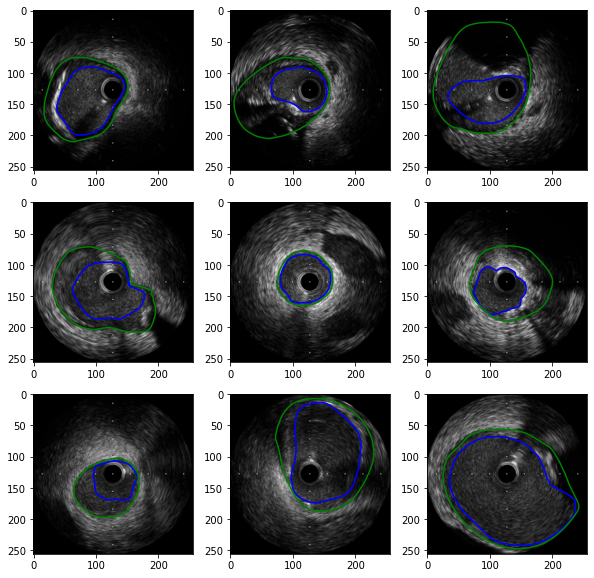

In [6]:
# Display some images
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-')
    plt.imshow(x_train_ds[i][2], cmap='gray')

### Create a set of mask images
We will use the labels we have to mask the interior of the paths they draw. Since we have three different classes: background, media and lumen; we will create a multiclass segmentation.

In [7]:
num_classes = 3
CLASSES = ['background', 'media', 'lumen']

In [8]:
def create_masks(x, y):
    """
    Create masks from a dataset and its labels
    
    parameters:
        x: dataset of images
        y: array of labels of 2D coordinates
    returns:
        An array containing multiclass images segmented as follows:
            - Value 0 represents background
            - Value 1 represents the media
            - Value 2 represents the lumen
    """
    
    masks = []

    for i in range(y['lum'].shape[0]):
        # Retrieve path from the label
        path_lum = Path(y['lum'][i])
        path_med = Path(y['med'][i])
        img = x[i][2]

        # Create a matrix of coordinates to check which points are inside the closed path
        img_meshgrid = np.array(np.meshgrid(*(np.arange(s) for s in img.shape[:2]), indexing='xy'))
        img_coordinates = img_meshgrid.transpose([1,2,0]).reshape(img.shape[0]*img.shape[1],2)
        mask_lum = path_lum.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])
        mask_med = path_med.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])

        final_mask = mask_lum.astype(int) + mask_med.astype(int)
        
        masks.append(final_mask)
        
    return np.array(masks)

def get_one_hot(targets, nb_classes):
    """Returns the targets as one-hot encoded"""
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### One-hot encoding
We one-hot encode our labels in the following way:
- Background pixels: [1, 0, 0]
- Media pixels: [0, 1, 0]
- Lumen pixels: [0, 0, 1]

This encoding will help optimize our model because we plan to output the probability of each pixel belonging to a certain class.

In [9]:
masks = np.concatenate(
    [create_masks(x_train_ds, observer_labels) for observer_labels in y_train_label_ds]
)
    
y_train_ds = get_one_hot(masks, num_classes)
x_train_ds = np.concatenate([x_train_ds for _ in range(len(y_train_label_ds))])

In [10]:
# GET TEST IMAGES
masks = np.concatenate(
    [create_masks(x_test_ds, observer_labels) for observer_labels in y_test_label_ds]
)
    
y_test_ds = get_one_hot(masks, num_classes)
x_test_ds = np.concatenate([x_test_ds for _ in range(len(y_test_label_ds))])

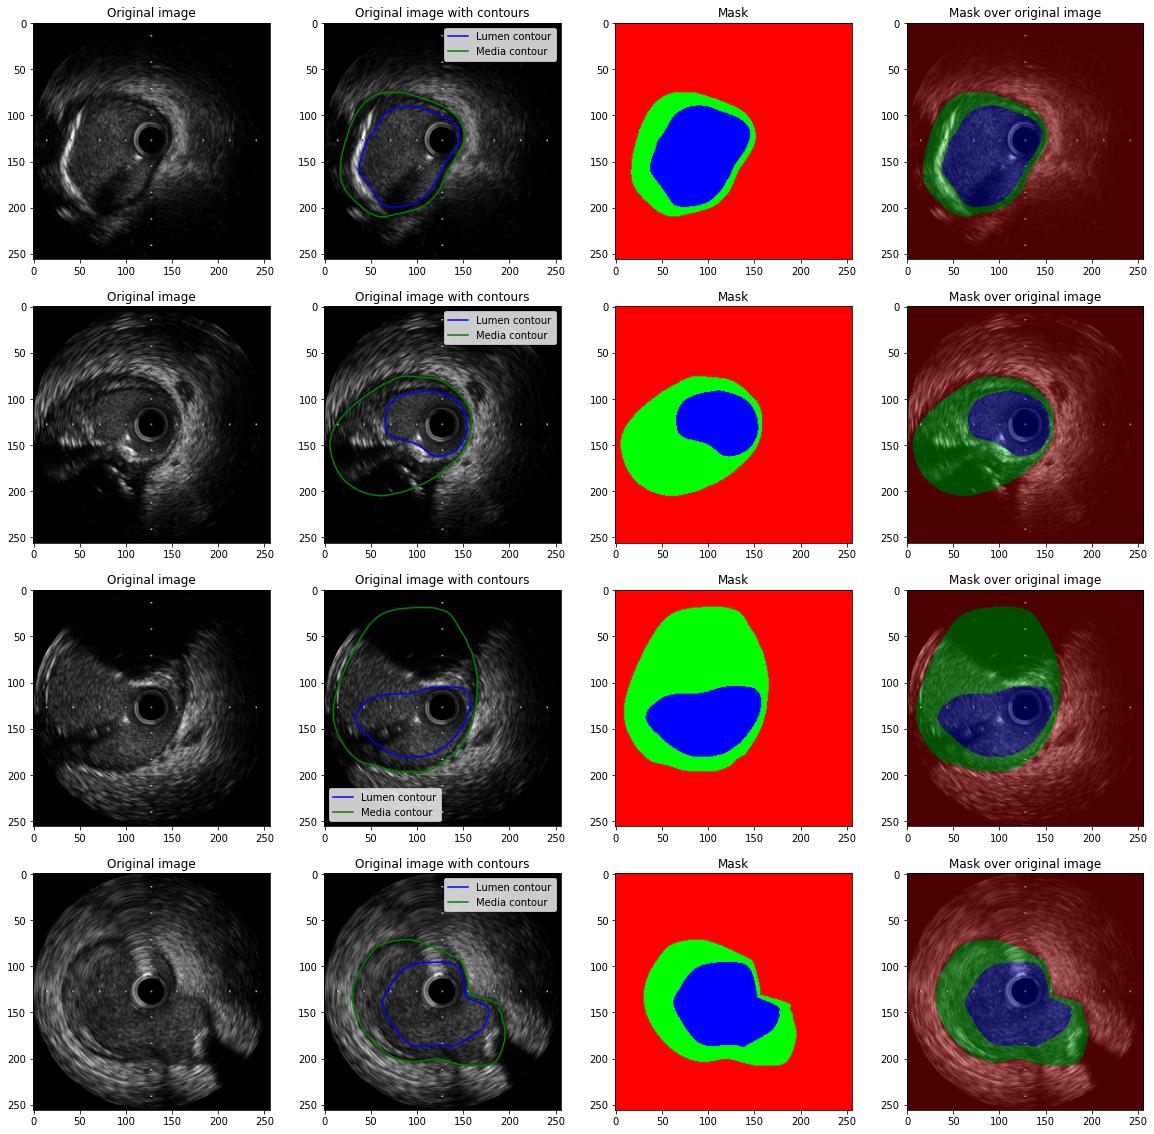

In [11]:
# Let's show some examples
plt.figure(figsize=(20, 20))

samples = 4

for i in range(samples):
    
    
    ax = plt.subplot(samples, 4, 4*i + 1)
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image')
    
    ax = plt.subplot(samples, 4, 4*i + 2)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-', label='Lumen contour')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-', label='Media contour')
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image with contours')
    plt.legend()
    
    
    mask = y_train_ds[i]/y_train_ds.max()
    ax = plt.subplot(samples, 4, 4*i + 3)
    plt.imshow(mask)
    plt.title('Mask')
    
    
    image = np.repeat(x_train_ds[i][2][..., np.newaxis], 3, axis=2)
    alpha = 0.7
    ax = plt.subplot(samples, 4, 4*i + 4)
    plt.imshow(np.uint8(image*alpha + mask*255*(1-alpha)))
    plt.title('Mask over original image')

### Data augmentation
We have 19 images to train using dataset A and 109 images in dataset B. Therefore we should apply Data Augmentation in order to get more training examples to feed into our model.

In this test we will only use the images adjacent to the middle image and we will pass these 3 images as 3 channels RGB to the data generator.

In [12]:
images = x_train_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (109, 384, 384, 3) (for dataset B)
masks = y_train_ds # Now the shape is (109, 384, 384, channels) (for dataset B)
num_classes = 3

print(f"Shape of set images: {images.shape}")
print(f"Shape of set masks: {masks.shape}")


batch_size = 8
input_shape = images.shape[1:] # (384, 384, 3)

images_test = x_test_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (num_images, 384, 384, 3) (for dataset B)
masks_test = np.copy(y_test_ds) # Now the shape is (num_images, 192, 192, channels) (for dataset B)

    
print(f"Shape of set images_test: {images_test.shape}")
print(f"Shape of set masks_test: {masks_test.shape}")

Shape of set images: (19, 256, 256, 3)
Shape of set masks: (19, 256, 256, 3)
Shape of set images_test: (174, 256, 256, 3)
Shape of set masks_test: (174, 256, 256, 3)


In [13]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20

def get_image_generator(data_gen_args=dict(data_format="channels_last", validation_split=0.15),
                        images=images,
                        masks=masks,
                        batch_size=batch_size):
    # we create two instances with the same arguments
    val_data_gen_args = dict(
        data_format=data_gen_args['data_format'],
        validation_split=data_gen_args['validation_split']
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    val_datagen = ImageDataGenerator(**val_data_gen_args)

    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    # Provide the same seed and keyword arguments to the fit and flow methods
    image_generator = image_datagen.flow(images, seed=seed, batch_size=batch_size, subset='training')
    mask_generator = mask_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='training')

    image_val_generator = val_datagen.flow(images, seed=seed, batch_size=batch_size, subset='validation')
    mask_val_generator = val_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='validation')

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    val_generator = zip(image_val_generator, mask_val_generator)
    
    return train_generator, val_generator

def gen_dtype(gen):
    while True:
        for i,j in gen:
            yield (i.astype('float32'), j.astype('float32'))

#def gen_dtype_test(gen):
#    for i,j in gen:
#        yield (i.astype('float32'), to_categorical(j.astype('int'), num_classes=num_classes))

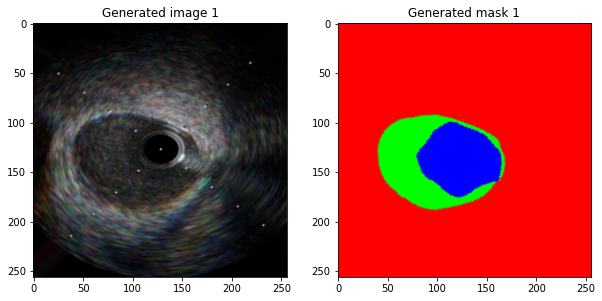

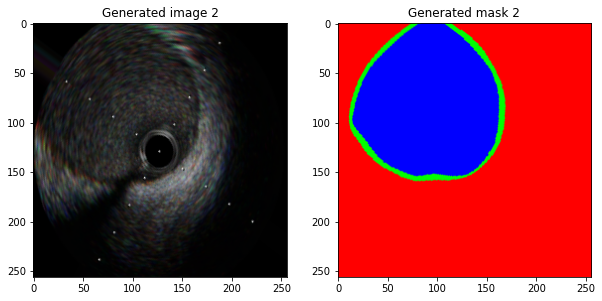

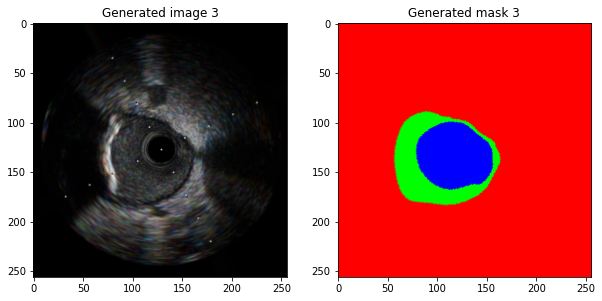

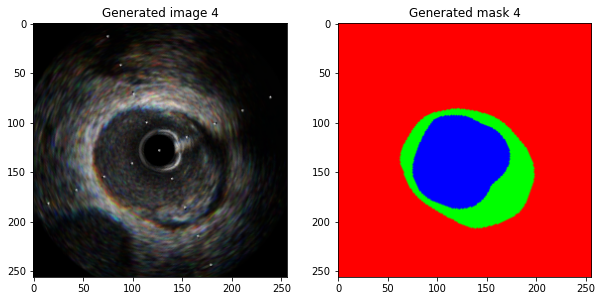

In [14]:
# Let's show some example
data_gen_args = dict(
    rotation_range=90,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0.15
)
train_generator, val_generator = get_image_generator(data_gen_args)
images_gen, masks_gen = next(gen_dtype(train_generator))
samples = len(images_gen)

for i in range(4):
    plt.figure(figsize=(10,100))
    plt.subplot(samples, 2, 2*i+1)
    plt.imshow(images_gen[i], cmap='gray')
    plt.title(f"Generated image {i+1}")
    
    plt.subplot(samples, 2, 2*i+2)
    plt.imshow(masks_gen[i])
    plt.title(f"Generated mask {i+1}")

## Prepare and train the model
In this test we will use the <i>U-Net Xception-style</i> model from [this tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


def get_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(input_shape, num_classes)
model.summary()

2022-01-17 19:29:58.179927: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-17 19:29:58.210910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 19:29:58.211059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 with Max-Q Design computeCapability: 6.1
coreClock: 1.48GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-17 19:29:58.211090: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-17 19:29:58.221181: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-17 19:29:58.221235: I tensorflow/st

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## K-Fold crossvalidation

In [16]:
# Classification metrics
def get_specificity(col, cm):
    """Return the specificity of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tn)/float(tn+fp)

def get_accuracy(col, cm):
    """Return the accuracy of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tp+tn)/float(tp+tn+fp+fn)

from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
from skimage.metrics import hausdorff_distance
import pandas as pd

def custom_classification_report(y_true, y_pred, classes=['background', 'media', 'lumen']):
    
    # Obtain precision, recall, f1-score and support
    data = classification_report(
        y_true.flatten(),
        y_pred.flatten(),
        output_dict=True,
        target_names=classes
    )
    data.pop('macro avg')
    data.pop('weighted avg')
    data.pop('accuracy')
    
    # Get jaccard score
    jacc = jaccard_score(
        y_true.flatten(),
        y_pred.flatten(),
        average=None
    )
    
    # Compute hausdorff distance of every image
    hausdorff_dist_list = np.zeros((len(classes), len(y_true)))
    for i in range(len(y_true)):
        # Ground truth
        gt = y_true[i]
        # Predicted segmentation
        seg = y_pred[i]

        # Evaluate for each class
        for j in range(len(classes)):
            hausdorff_dist_list[j, i] = hausdorff_distance(gt==j, seg==j)
    hd = hausdorff_dist_list
    
    # Finally compute specificity
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    for i in range(len(classes)):
        data[classes[i]]['specificity'] = get_specificity(i, cm)
        data[classes[i]]['accuracy'] = get_accuracy(i, cm)
        data[classes[i]]['jaccard_score'] = jacc[i]
        data[classes[i]]['hausdorff_dist'] = hd[i]
    
    return pd.DataFrame(data)

In [17]:
from sklearn.model_selection import KFold

def load_data_kfold(k):
    folds = list(KFold(n_splits=k, shuffle=True, random_state=seed).split(images, masks))
    return folds, images, masks

def get_callbacks(name_weights, patience_lr):
    mcp_save = keras.callbacks.ModelCheckpoint(
        name_weights,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.1,
        patience=patience_lr,
        verbose=1,
        min_delta=1e-4,
        mode='min'
    )
    return [reduce_lr_loss]

loss = keras.losses.CategoricalCrossentropy()
metrics = ["categorical_accuracy"]
data_gen_args = dict(
    rotation_range=90,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0
)

In [18]:
foldsA = [(0,
  (np.array([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17]),
   np.array([ 4,  5, 16, 18]))),
 (1,
  (np.array([ 1,  2,  3,  4,  5,  6,  9, 10, 11, 13, 14, 15, 16, 17, 18]),
   np.array([ 0,  7,  8, 12]))),
 (2,
  (np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 16, 17, 18]),
   np.array([ 9, 11, 14, 15]))),
 (3,
  (np.array([ 0,  2,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18]),
   np.array([ 1,  3,  6, 10]))),
 (4,
  (np.array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 18]),
   np.array([ 2, 13, 17])))]


Fold  0


2022-01-17 19:30:00.169221: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-17 19:30:00.186302: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz
2022-01-17 19:30:01.638642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-17 19:30:01.990076: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-01-17 19:30:02.250825: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-17 19:30:02.250850: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-01-17 19:30:02.251236: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-17 19:30:02.251285: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31


Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00228: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 00238: ReduceL

background  \
precision                                                0.946257   
recall                                                   0.971844   
f1-score                                                  0.95888   
support                                                   8774622   
specificity                                              0.784384   
accuracy                                                 0.933637   
jaccard_score                                            0.921009   
hausdorff_dist  [25.079872407968907, 24.08318915758459, 22.472...   

                                                            media  \
precision                                                0.582269   
recall                                                   0.557921   
f1-score                                                 0.569835   
support                                                   1267864   
specificity                                              0.949703   
accuracy                                                 0.905967   
jaccard_score                                             0.39844   
hausdorff_dist  [40.0, 41.0, 64.32728814430156, 34.01470270338...   

                                                            lumen  
precision                                                0.896321  
recall                                                   0.774957  
f1-score                                                 0.831232  
support                                                   1360778  
specificity                                              0.986964  
accuracy                                                 0.960046  
jaccard_score                                            0.711204  
hausdorff_dist  [9.0, 15.620499351813308, 22.627416997969522, ...


Fold  1

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00104: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00147: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00167: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00207: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00227: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 00237

background  \
precision                                                0.938205   
recall                                                   0.974523   
f1-score                                                 0.956019   
support                                                   8774622   
specificity                                              0.745376   
accuracy                                                 0.928388   
jaccard_score                                            0.915744   
hausdorff_dist  [19.313207915827967, 29.017236257093817, 18.97...   

                                                            media  \
precision                                                0.553334   
recall                                                   0.530245   
f1-score                                                 0.541544   
support                                                   1267864   
specificity                                               0.94611   
accuracy                                                 0.899607   
jaccard_score                                            0.371313   
hausdorff_dist  [18.027756377319946, 42.0, 61.98386886924694, ...   

                                                            lumen  
precision                                                0.909176  
recall                                                   0.717579  
f1-score                                                 0.802095  
support                                                   1360778  
specificity                                              0.989535  
accuracy                                                 0.954889  
jaccard_score                                            0.669581  
hausdorff_dist  [9.055385138137417, 21.95449840010015, 26.0192...


Fold  2

Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00146: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00187: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00197: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00207: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00239: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.
6/6 [==============================] - 1s 204ms/step - loss: 0.4595 - categorical_accuracy: 0.

background  \
precision                                                 0.95055   
recall                                                   0.969234   
f1-score                                                 0.959801   
support                                                   8774622   
specificity                                              0.801424   
accuracy                                                 0.935253   
jaccard_score                                            0.922709   
hausdorff_dist  [22.80350850198276, 19.4164878389476, 17.02938...   

                                                            media  \
precision                                                0.571743   
recall                                                   0.582238   
f1-score                                                 0.576942   
support                                                   1267864   
specificity                                              0.945281   
accuracy                                                 0.904808   
jaccard_score                                            0.405424   
hausdorff_dist  [21.213203435596427, 21.400934559032695, 23.02...   

                                                            lumen  
precision                                                0.899033  
recall                                                   0.769707  
f1-score                                                 0.829359  
support                                                   1360778  
specificity                                              0.987433  
accuracy                                                 0.959799  
jaccard_score                                            0.708465  
hausdorff_dist  [9.0, 21.633307652783937, 22.47220505424423, 3...


Fold  3

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00134: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00146: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00206: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00216: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00226: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.

Epoch 00241

background  \
precision                                                0.942249   
recall                                                   0.973046   
f1-score                                                   0.9574   
support                                                   8774622   
specificity                                              0.769266   
accuracy                                                 0.931192   
jaccard_score                                            0.918281   
hausdorff_dist  [22.627416997969522, 20.8806130178211, 16.9705...   

                                                            media  \
precision                                                0.592025   
recall                                                   0.510025   
f1-score                                                 0.547974   
support                                                   1267864   
specificity                                                0.9558   
accuracy                                                 0.906003   
jaccard_score                                            0.377386   
hausdorff_dist  [26.076809620810597, 21.213203435596427, 42.19...   

                                                            lumen  
precision                                                0.878742  
recall                                                   0.806941  
f1-score                                                 0.841312  
support                                                   1360778  
specificity                                              0.983771  
accuracy                                                 0.961276  
jaccard_score                                             0.72609  
hausdorff_dist  [11.704699910719626, 18.35755975068582, 25.632...


Fold  4

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00152: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00172: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00198: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00208: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00228: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
6/6 [=======

background  \
precision                                                0.945025   
recall                                                    0.97457   
f1-score                                                  0.95957   
support                                                   8774622   
specificity                                              0.779535   
accuracy                                                 0.934675   
jaccard_score                                            0.922282   
hausdorff_dist  [21.18962010041709, 22.360679774997898, 21.931...   

                                                            media  \
precision                                                0.601212   
recall                                                   0.538626   
f1-score                                                 0.568201   
support                                                   1267864   
specificity                                              0.955064   
accuracy                                                 0.908539   
jaccard_score                                            0.396844   
hausdorff_dist  [20.12461179749811, 20.615528128088304, 30.149...   

                                                            lumen  
precision                                                0.883162  
recall                                                    0.79078  
f1-score                                                 0.834422  
support                                                   1360778  
specificity                                              0.984818  
accuracy                                                 0.960227  
jaccard_score                                            0.715887  
hausdorff_dist  [17.46424919657298, 19.4164878389476, 20.80865...

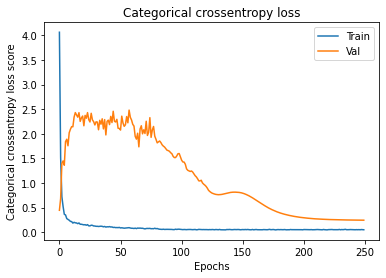

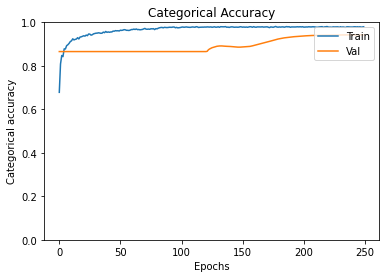

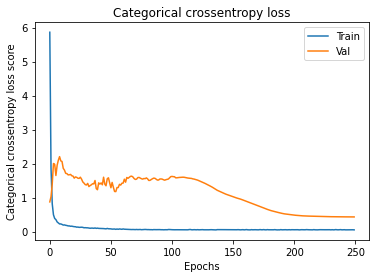

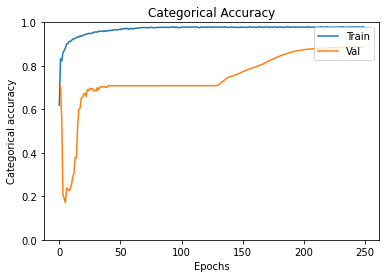

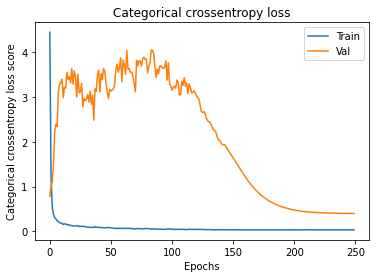

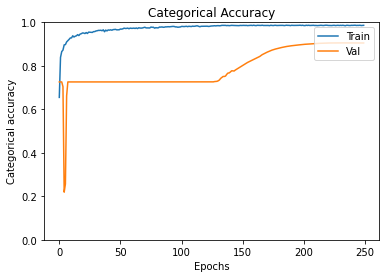

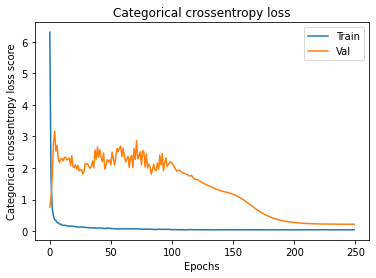

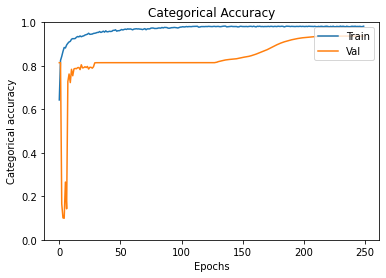

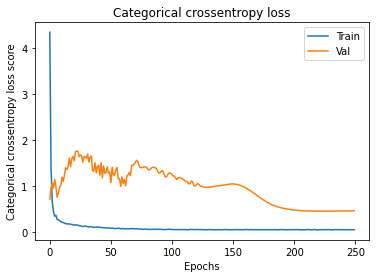

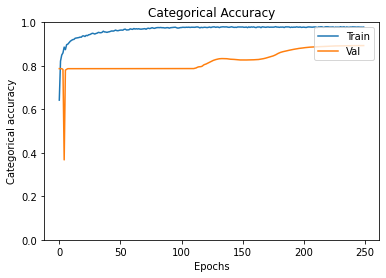

In [19]:
from tensorflow.keras import backend as K

# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)

data_by_fold = []

for j, (train_idx, val_idx) in foldsA:
    
    # Free up RAM in case the model definition cells were run multiple times
    K.clear_session()
    epochs = 250
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-05, decay=0.0)
    
    print('\nFold ',j)
    X_train_cv = images[train_idx]
    y_train_cv = masks[train_idx]
    X_valid_cv = images[val_idx]
    y_valid_cv = masks[val_idx]
    
    name_weights = ""
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    train_generator, val_generator = get_image_generator(data_gen_args, images=X_train_cv, masks=y_train_cv)
    
    model = get_model(input_shape, num_classes)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    history = model.fit(
        gen_dtype(train_generator),
        validation_data=(X_valid_cv, y_valid_cv),
        shuffle=True,
        steps_per_epoch=5*len(X_train_cv)/batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )
    
    f1 = plt.figure(2*j+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Categorical crossentropy loss')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical crossentropy loss score')
    plt.legend(['Train', 'Val'], loc='upper right')
    f1.show()

    f2 = plt.figure(2*j+2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Categorical Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical accuracy')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f2.show()
    
    score = model.evaluate(images_test, masks_test, verbose=1)
    
    masks_test_from_pred = get_class_mask_from_prediction(masks_test)
    prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in model.predict(images_test)])
    
    df = custom_classification_report(masks_test_from_pred, prediction_masks_test)
    
    display(df)
    
    data_by_fold.append(df)

In [20]:
data = data_by_fold[0].copy(deep=True)
for cls in ['background', 'media', 'lumen']:
    for metric in ['precision', 'recall', 'f1-score', 'accuracy', 'specificity', 'jaccard_score']:
        l = [fold[cls][metric] for fold in data_by_fold]
        data[cls][metric] = f"{np.mean(l)}({np.std(l)})"
    
    hausdorff_list = []
    for fold in data_by_fold:
        hausdorff_list += list(fold[cls]['hausdorff_dist'])
    
    data[cls]['hausdorff_dist'] = f"{np.mean(hausdorff_list)}({np.std(hausdorff_list)})"
    
display(data)
data.to_csv(os.path.join(os.path.dirname(os.getcwd()), "output", f"v{version}", "metrics-modelA-datasetA.csv"))

background  \
precision        0.9444571740136437(0.004114663198433323)   
recall           0.972643607895588(0.0019833630170543698)   
f1-score         0.9583341186488349(0.001428954966313492)   
support                                           8774622   
specificity      0.7759971954502701(0.018505747852885026)   
accuracy        0.9326290517685341(0.0025350622112632927)   
jaccard_score   0.9200050578997592(0.0026318796109156355)   
hausdorff_dist     25.970506465783128(10.122101157454974)   

                                                   media  \
precision       0.5801165617865424(0.016606715332198707)   
recall          0.5438108503751191(0.024609420978843357)   
f1-score         0.560899179558326(0.013654626093295059)   
support                                          1267864   
specificity     0.9503916610688247(0.004382130568485546)   
accuracy        0.9049847865119137(0.002952599635237813)   
jaccard_score   0.3898814379217682(0.013147194163565171)   
hausdorff_dist      32.5992437182322(14.262308611523345)   

                                                    lumen  
precision        0.8932869331610627(0.011034107091603032)  
recall           0.7719926395047538(0.030163407153413632)  
f1-score         0.8276839105708987(0.013426343134240404)  
support                                           1360778  
specificity      0.9865040169086197(0.002028557204092724)  
accuracy        0.9592474543334024(0.0022365068391436162)  
jaccard_score    0.7062454453928663(0.019290257360851378)  
hausdorff_dist     23.563793056491253(13.820626822122499)

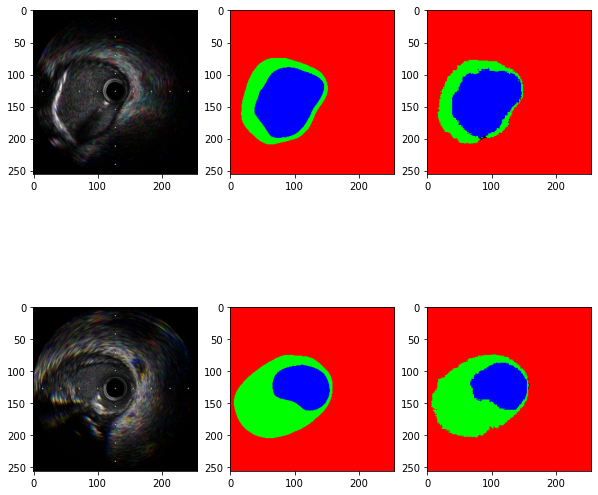

In [21]:
# Show some predictions from the training dataset
plt.figure(figsize=(10,10))

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

best_model = model

samples = 2

test_images = images[:samples]
test_masks = masks[:samples]
test_predictions = best_model.predict(test_images)

for i in range(samples):
    
    plt.subplot(samples, 3, 3*i + 1)
    plt.imshow(test_images[i])
    
    plt.subplot(samples, 3, 3*i + 2)
    plt.imshow(test_masks[i])
    
    plt.subplot(samples, 3, 3*i + 3)
    plt.imshow(get_mask_from_prediction(test_predictions[i]))

## Let's test our model

In [22]:
score = model.evaluate(images_test, masks_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

6/6 [==============================] - 1s 200ms/step - loss: 0.3743 - categorical_accuracy: 0.9042
Test loss: 0.37430229783058167
Test accuracy: 0.9041677713394165


In [29]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

def print_predictions(image, ground_truth, prediction, save_filename=None):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 5, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    plt.subplot(1, 5, 2)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(ground_truth)
    
    plt.subplot(1, 5, 3)
    plt.title("Prediction")
    plt.axis('off')
    plt.imshow(prediction) 

    handles = [
        mpatches.Patch(color='red', label='Ground Truth & Not Predicted'),
        mpatches.Patch(color='xkcd:green', label='Not Ground Truth & Predicted'),
        mpatches.Patch(color='blue', label='Ground Truth & Predicted')
    ]
    
    media_image = np.zeros(image.shape)
    media_image[:, :, 0][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==0)] = 1
    media_image[:, :, 1][(ground_truth[:, :, 1]==0) & (prediction[:, :, 1]==1)] = 1
    media_image[:, :, 2][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==1)] = 1
    plt.subplot(1, 5, 4)
    plt.title("Media prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(media_image)
    
    lumen_image = np.zeros(image.shape)
    lumen_image[:, :, 0][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==0)] = 1
    lumen_image[:, :, 1][(ground_truth[:, :, 2]==0) & (prediction[:, :, 2]==1)] = 1
    lumen_image[:, :, 2][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==1)] = 1
    plt.subplot(1, 5, 5)
    plt.title("Lumen prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(lumen_image)
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", "A", "predictions", save_filename))

<Figure size 720x2880 with 0 Axes>

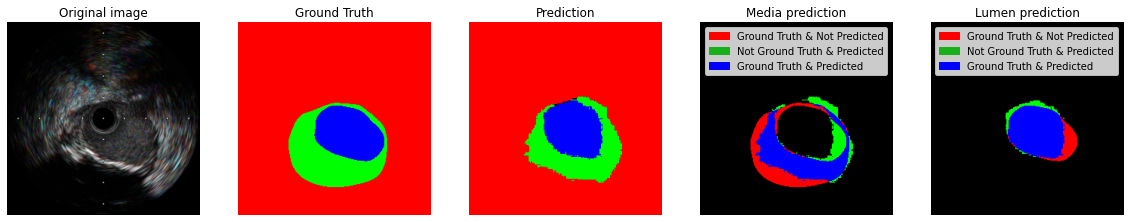

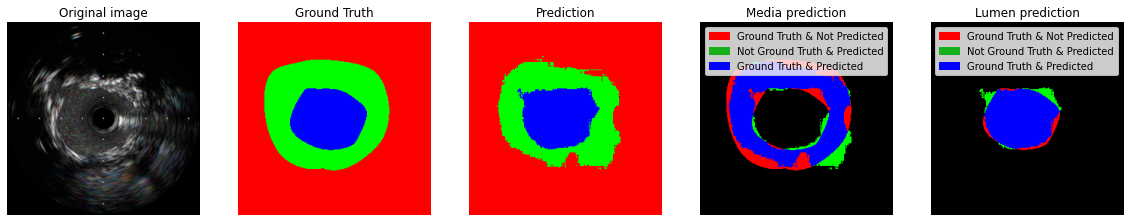

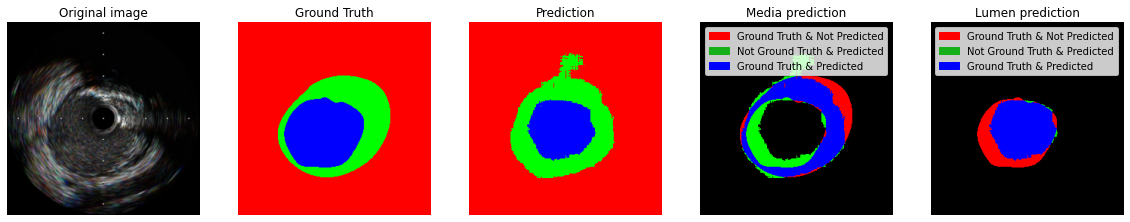

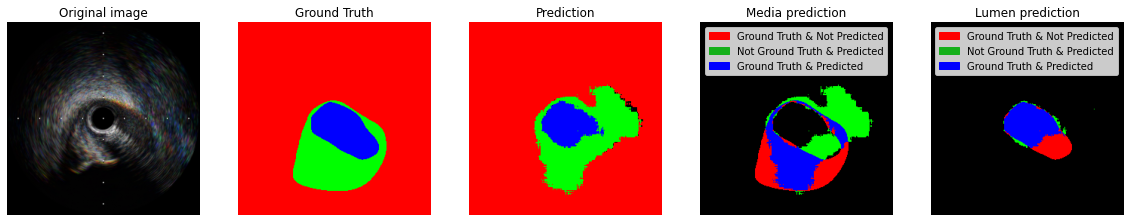

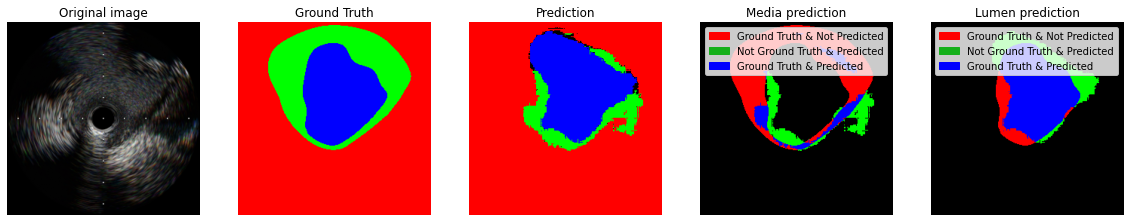

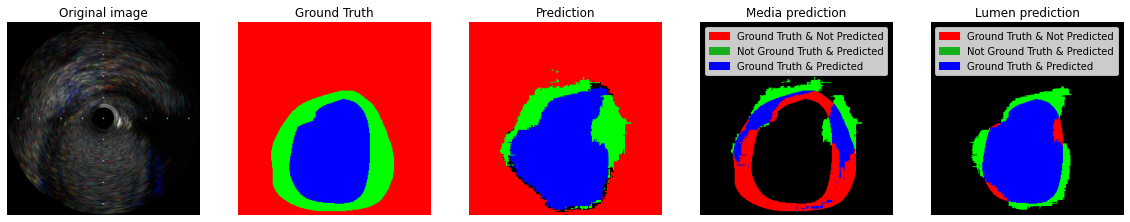

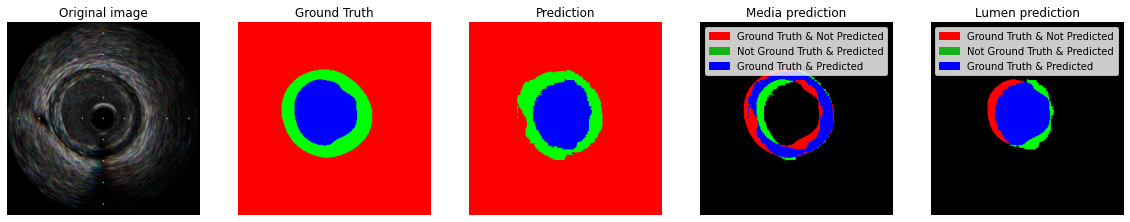

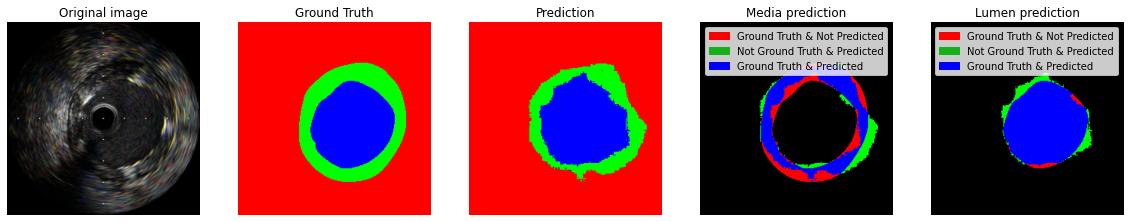

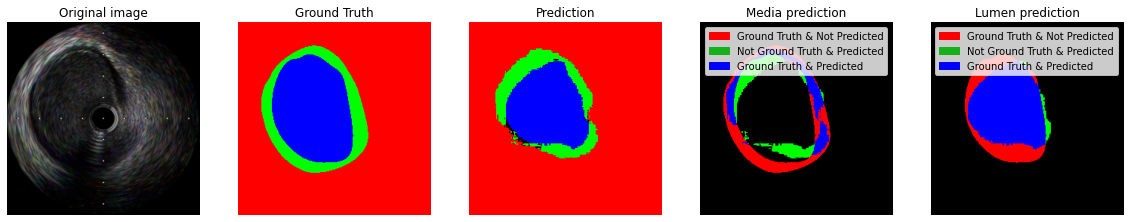

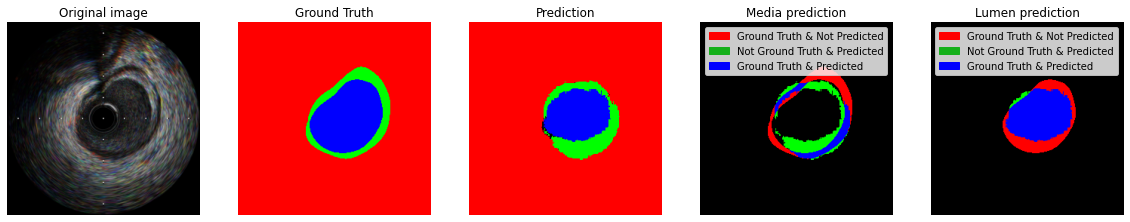

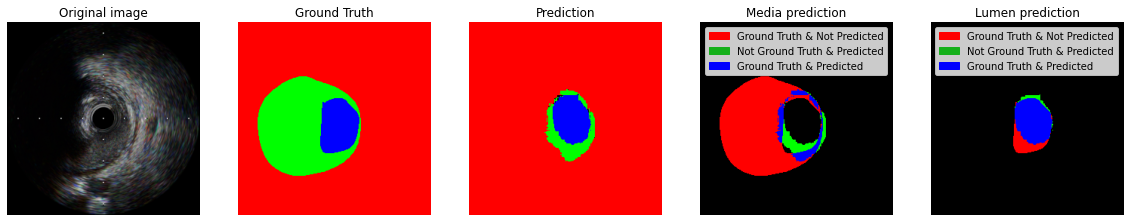

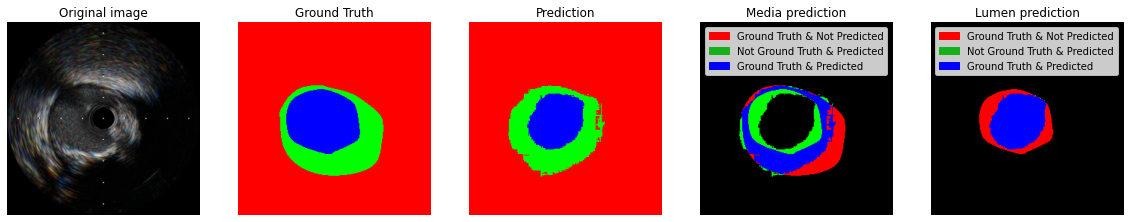

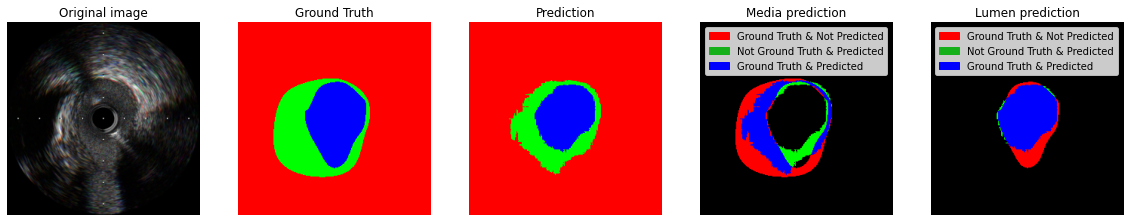

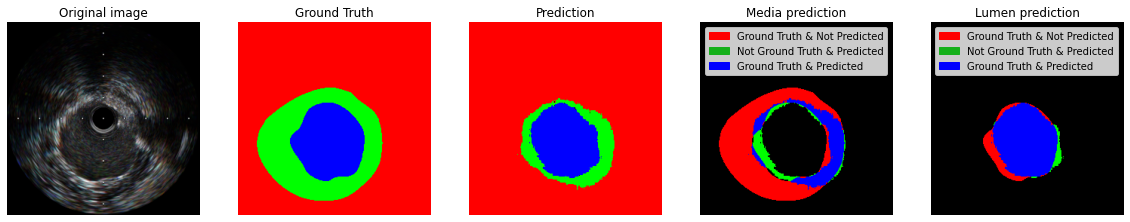

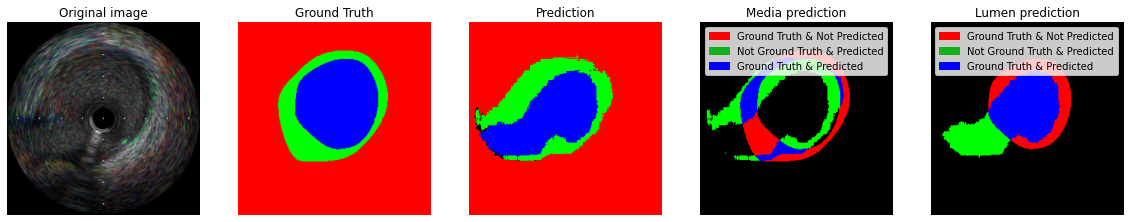

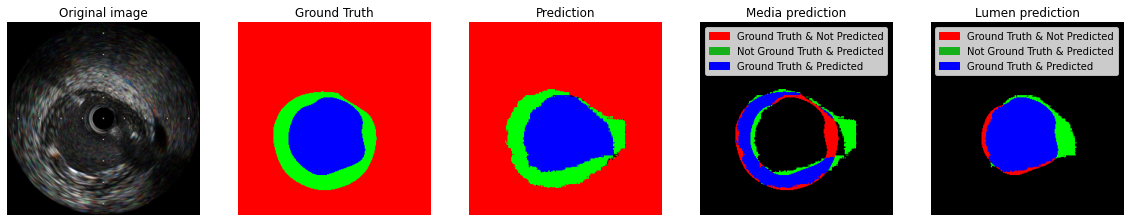

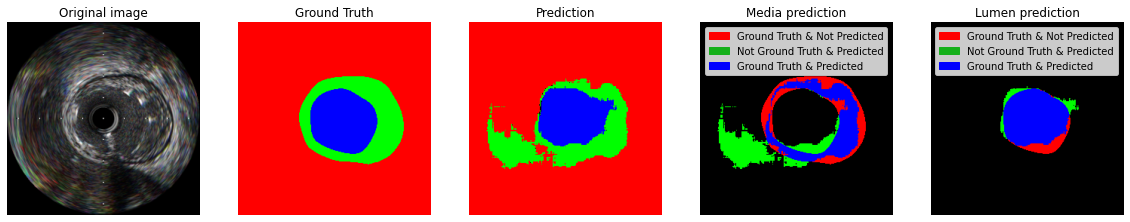

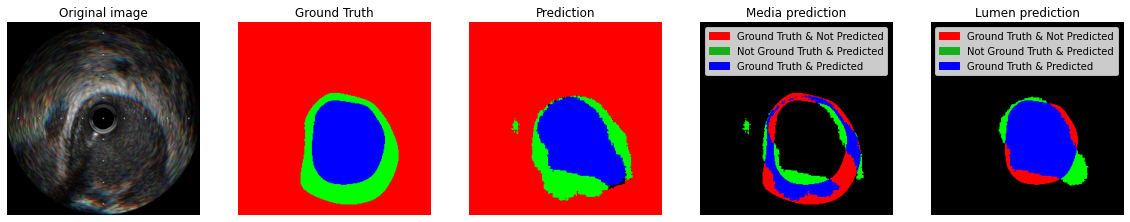

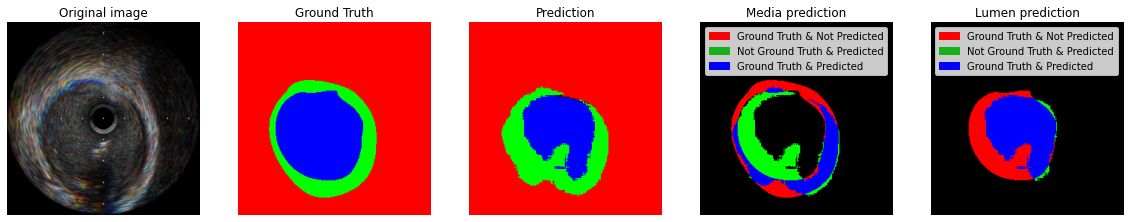

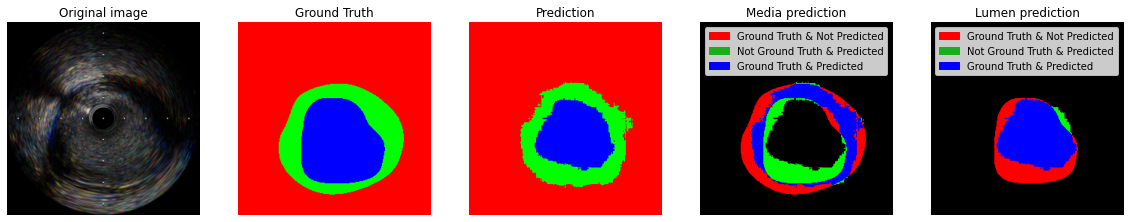

In [30]:
# Show some predictions from the test dataset
plt.figure(figsize=(10,40))

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

samples = 20

test_images = images_test[:samples]
test_masks = masks_test[:samples]
test_predictions = model.predict(test_images)

for i in range(samples):
    save_filename=f"frame_{20+i:02}_00{20+i:02}_003.png"
    print_predictions(
        test_images[i],
        test_masks[i],
        get_mask_from_prediction(test_predictions[i]),
        save_filename=save_filename
    )

In [31]:
# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)
    
masks_test = get_class_mask_from_prediction(masks_test)
prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in best_model.predict(images_test)])

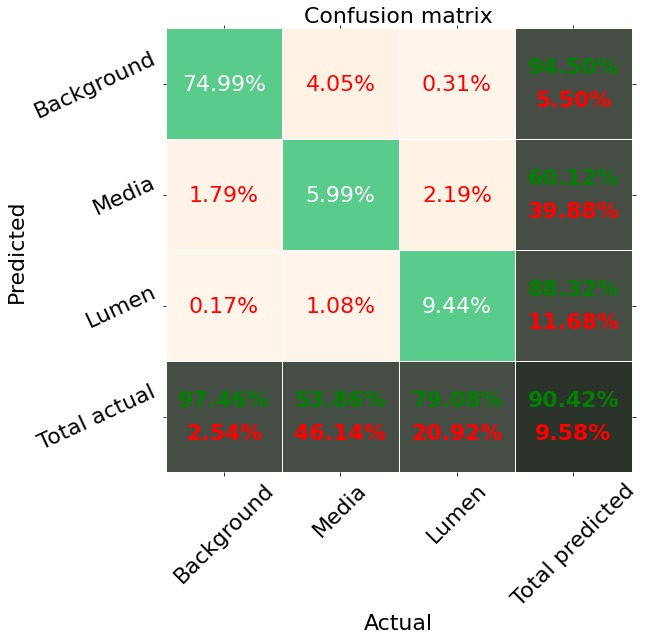

In [33]:
from confusion_matrix_pretty_print import pp_matrix_from_data
pp_matrix_from_data(
    masks_test.flatten(),
    prediction_masks_test.flatten(),
    columns=['Background', 'Media', 'Lumen'],
    fz=22
)